# Crop Yield Prediction – Final Model Pipeline (Rev6)

## 1. Setup & Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import shap

np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')
print("All libraries loaded.")

All libraries loaded.


## 2. Model Selection Menu

In [35]:
RUN_MODELS = {
    'LR': True,   # Baseline Linear Regression
    'RF': True,   # Random Forest
    'XGB': True,  # XGBoost
    'LSTM': True, # LSTM
    'CNN': True   # CNN
}

RUN_OPTUNA = True

## 3. Load & Preprocess Data

In [36]:
try:
    df = pd.read_csv("cleaned_crop_data.csv")
    print(f"Loaded: {df.shape}")
except:
    raise FileNotFoundError("Run EDA first!")

TARGET = 'hg/ha_yield'
TIME_COL = 'Year'
CAT_COLS = ['Area', 'Item']
NUMERIC_COLS = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'fertilizer_kg/ha', 'solar_radiation_MJ/m2-day']

# De-trend per group
df = df.sort_values(CAT_COLS + [TIME_COL])
df['yield_detrended'] = df.groupby(CAT_COLS)[TARGET].transform(detrend)
df['yield_trend'] = df[TARGET] - df['yield_detrended']
TARGET_DET = 'yield_detrended'

# Lags for ML
LAG_COLS = [TARGET_DET] + NUMERIC_COLS
for col in LAG_COLS:
    for lag in [1, 2]:
        df[f'{col}_lag{lag}'] = df.groupby(CAT_COLS)[col].shift(lag)
df_ml = df.dropna().copy()

# Split
TRAIN_END = 2007
VAL_END = 2010
train_df = df_ml[df_ml[TIME_COL] <= TRAIN_END].copy()
val_df = df_ml[(df_ml[TIME_COL] > TRAIN_END) & (df_ml[TIME_COL] <= VAL_END)].copy()
test_df = df_ml[df_ml[TIME_COL] > VAL_END].copy()

# Encode
le_area = LabelEncoder().fit(df_ml['Area'])
le_item = LabelEncoder().fit(df_ml['Item'])
for d in [train_df, val_df, test_df]:
    d['Area_Encoded'] = le_area.transform(d['Area'])
    d['Item_Encoded'] = le_item.transform(d['Item'])

# Scale
lagged_cols = [c for c in df_ml.columns if '_lag' in c]
scale_cols = NUMERIC_COLS + lagged_cols
scaler = StandardScaler()
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
val_df[scale_cols] = scaler.transform(val_df[scale_cols])
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le_area, 'le_area.joblib')
joblib.dump(le_item, 'le_item.joblib')

N_AREAS = len(le_area.classes_)
N_ITEMS = len(le_item.classes_)

Loaded: (25932, 9)


## 4. Prepare Inputs

In [37]:
# ML
ML_FEATS = NUMERIC_COLS + lagged_cols + ['Area_Encoded', 'Item_Encoded']
X_train_ml = train_df[ML_FEATS]
y_train_ml = train_df[TARGET_DET]
X_val_ml = val_df[ML_FEATS]
y_val_ml = val_df[TARGET_DET]
X_test_ml = test_df[ML_FEATS]
y_test_ml = test_df[TARGET_DET]

# DL Sequences
LOOKBACK = 5
DL_FEATS = NUMERIC_COLS + ['Area_Encoded', 'Item_Encoded']

def create_sequences(data, lookback, feats, target):
    X, y = [], []
    for _, group in data.groupby(CAT_COLS):
        if len(group) < lookback:
            continue
        gf = group[feats].values
        gt = group[target].values
        for i in range(len(group) - lookback + 1):
            X.append(gf[i:i+lookback])
            y.append(gt[i+lookback-1])
    return np.array(X), np.array(y)

scaler_dl = StandardScaler()
target_scaler = StandardScaler()
train_df_dl = df[df[TIME_COL] <= TRAIN_END].copy()
val_df_dl = df[(df[TIME_COL] > TRAIN_END) & (df[TIME_COL] <= VAL_END)].copy()
test_df_dl = df[df[TIME_COL] > VAL_END].copy()
train_df_dl['Area_Encoded'] = le_area.transform(train_df_dl['Area'])
train_df_dl['Item_Encoded'] = le_item.transform(train_df_dl['Item'])
val_df_dl['Area_Encoded'] = le_area.transform(val_df_dl['Area'])
val_df_dl['Item_Encoded'] = le_item.transform(val_df_dl['Item'])
test_df_dl['Area_Encoded'] = le_area.transform(test_df_dl['Area'])
test_df_dl['Item_Encoded'] = le_item.transform(test_df_dl['Item'])
train_df_dl[NUMERIC_COLS] = scaler_dl.fit_transform(train_df_dl[NUMERIC_COLS])
val_df_dl[NUMERIC_COLS] = scaler_dl.transform(val_df_dl[NUMERIC_COLS])
test_df_dl[NUMERIC_COLS] = scaler_dl.transform(test_df_dl[NUMERIC_COLS])

# Fit scaler on train target only
train_df_dl[TARGET_DET] = target_scaler.fit_transform(train_df_dl[[TARGET_DET]])
val_df_dl[TARGET_DET] = target_scaler.transform(val_df_dl[[TARGET_DET]])
test_df_dl[TARGET_DET] = target_scaler.transform(test_df_dl[[TARGET_DET]])

X_train_seq, y_train_seq = create_sequences(train_df_dl, LOOKBACK, DL_FEATS, TARGET_DET)
X_val_seq, y_val_seq = create_sequences(val_df_dl, LOOKBACK, DL_FEATS, TARGET_DET)
X_test_seq, y_test_seq = create_sequences(test_df_dl, LOOKBACK, DL_FEATS, TARGET_DET)

def split_dl(X):
    return [
        torch.tensor(X[..., :-2], dtype=torch.float32),
        torch.tensor(X[..., -2], dtype=torch.long),
        torch.tensor(X[..., -1], dtype=torch.long)
    ]

X_train_dl = split_dl(X_train_seq)
X_val_dl = split_dl(X_val_seq)
X_test_dl = split_dl(X_test_seq)

y_train_t = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1)

## 5. Metrics

In [38]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / (y_true + 1e-8)) ** 2)) * 100

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

## 6. Optuna Objectives

In [39]:
def objective_lr(trial):
    # No hyperparameters to tune for Linear Regression
    return 0

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_ml):
        model.fit(X_train_ml.iloc[train_idx], y_train_ml.iloc[train_idx])
        pred = model.predict(X_train_ml.iloc[val_idx])
        scores.append(rmspe(y_train_ml.iloc[val_idx], pred))
    return np.mean(scores)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }
    model = xgb.XGBRegressor(random_state=42, **params)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_ml):
        model.fit(X_train_ml.iloc[train_idx], y_train_ml.iloc[train_idx])
        pred = model.predict(X_train_ml.iloc[val_idx])
        scores.append(rmspe(y_train_ml.iloc[val_idx], pred))
    return np.mean(scores)

class LSTMModel(nn.Module):
    def __init__(self, n_areas, n_items, lstm_units, dense_units, dropout):
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.lstm = nn.LSTM(len(NUMERIC_COLS) + 10 + 5, lstm_units, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
    def forward(self, num, area, item):
        e_area = self.embed_area(area)
        e_item = self.embed_item(item)
        x = torch.cat([num, e_area, e_item], dim=-1)
        out, _ = self.lstm(x)
        out = self.drop(out[:, -1])
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

def train_dl(model, opt, loss_fn, train_loader, val_loader, target_scaler, epochs=100, patience=10, is_final=False):
    best_val_loss = float('inf')
    best_rmspe = float('inf')
    wait = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x1, x2, x3, y in train_loader:
            opt.zero_grad()
            pred = model(x1, x2, x3)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        model.eval()
        with torch.no_grad():
            val_inputs = [x.to(next(model.parameters()).device) for x in val_loader.dataset.tensors[:3]]
            val_y = val_loader.dataset.tensors[3]
            val_pred = model(*val_inputs)
            val_mse = loss_fn(val_pred, val_y).item()
            val_losses.append(val_mse)
            
            y_true_inv = target_scaler.inverse_transform(val_y.cpu().numpy())
            y_pred_inv = target_scaler.inverse_transform(val_pred.cpu().numpy())
            val_rmspe = rmspe(y_true_inv.flatten(), y_pred_inv.flatten())

        if val_mse < best_val_loss:
            best_val_loss = val_mse
            best_rmspe = val_rmspe
            wait = 0
            if is_final:
                torch.save(model.state_dict(), f'model_{model.__class__.__name__}.pth')
        else:
            wait += 1
            if wait >= patience:
                break
    return train_losses, val_losses, best_val_loss

def objective_lstm(trial):
    params = {
        'lstm_units': trial.suggest_categorical('lstm_units', [64, 128]),
        'dense_units': trial.suggest_categorical('dense_units', [32, 64]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    }
    lr = params.pop('lr')
    weight_decay = params.pop('weight_decay')
    model = LSTMModel(N_AREAS, N_ITEMS, **params)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)
    _, _, best_val_loss = train_dl(model, opt, nn.MSELoss(), train_loader, val_loader, target_scaler)
    return best_val_loss

class CNNModel(nn.Module):
    def __init__(self, n_areas, n_items, filters, kernel, dense_units): 
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.conv = nn.Conv1d(len(NUMERIC_COLS) + 10 + 5, filters, kernel)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(filters, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
    def forward(self, num, area, item):
        e_area = self.embed_area(area)
        e_item = self.embed_item(item)
        x = torch.cat([num, e_area, e_item], dim=-1).transpose(1, 2)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def objective_cnn(trial):
    params = {
        'filters': trial.suggest_categorical('filters', [64, 128]),
        'kernel': trial.suggest_categorical('kernel', [2, 3]),
        'dense_units': trial.suggest_categorical('dense_units', [32, 64]),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    }
    lr = params.pop('lr')
    weight_decay = params.pop('weight_decay')
    model = CNNModel(N_AREAS, N_ITEMS, **params)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)
    _, _, best_val_loss = train_dl(model, opt, nn.MSELoss(), train_loader, val_loader, target_scaler)
    return best_val_loss

## 7. Run Optuna

In [40]:
if os.path.exists('best_params_optuna.joblib'):
    best_params = joblib.load('best_params_optuna.joblib')
else:
    best_params = {}

if RUN_OPTUNA:
    studies = {}
    objectives = {
        'LR': objective_lr,
        'RF': objective_rf,
        'XGB': objective_xgb,
        'LSTM': objective_lstm,
        'CNN': objective_cnn
    }
    for name, run in RUN_MODELS.items():
        if run:
            print(f'--- Tuning {name} ---')
            study = optuna.create_study(direction='minimize')
            n_trials = 50 if name in ['RF', 'XGB'] else 30
            if name == 'LR':
                n_trials = 1
            study.optimize(objectives[name], n_trials=n_trials, show_progress_bar=True)
            best_params[name] = study.best_params
            studies[name] = study
            joblib.dump(best_params, 'best_params_optuna.joblib') # Save after each study
            print(f'Best params for {name}: {study.best_params}')
else:
    print('Skipping Optuna tuning.')

[I 2025-11-16 23:07:25,340] A new study created in memory with name: no-name-0fb59ec4-5e62-4d4b-985e-571bbdae4e4c


--- Tuning LR ---


Best trial: 0. Best value: 0: 100%|██████████| 1/1 [00:00<00:00, 473.45it/s]
[I 2025-11-16 23:07:25,346] A new study created in memory with name: no-name-fe7c56ac-cdf6-4cbf-93bb-38ab04121573


[I 2025-11-16 23:07:25,341] Trial 0 finished with value: 0.0 and parameters: {}. Best is trial 0 with value: 0.0.
Best params for LR: {}
--- Tuning RF ---


Best trial: 0. Best value: 1595.8:   2%|▏         | 1/50 [00:12<09:48, 12.00s/it]

[I 2025-11-16 23:07:37,349] Trial 0 finished with value: 1595.7985260497233 and parameters: {'n_estimators': 226, 'max_depth': 17, 'min_samples_leaf': 4, 'max_features': 0.7485666960700077}. Best is trial 0 with value: 1595.7985260497233.


Best trial: 0. Best value: 1595.8:   4%|▍         | 2/50 [00:17<06:45,  8.44s/it]

[I 2025-11-16 23:07:43,304] Trial 1 finished with value: 1883.7838361798226 and parameters: {'n_estimators': 294, 'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 0.9090297458005069}. Best is trial 0 with value: 1595.7985260497233.


Best trial: 2. Best value: 1577.33:   6%|▌         | 3/50 [00:35<09:59, 12.76s/it]

[I 2025-11-16 23:08:01,189] Trial 2 finished with value: 1577.3269936642353 and parameters: {'n_estimators': 389, 'max_depth': 23, 'min_samples_leaf': 7, 'max_features': 0.5647152703604161}. Best is trial 2 with value: 1577.3269936642353.


Best trial: 2. Best value: 1577.33:   8%|▊         | 4/50 [00:42<07:57, 10.37s/it]

[I 2025-11-16 23:08:07,909] Trial 3 finished with value: 1608.7896273397976 and parameters: {'n_estimators': 167, 'max_depth': 9, 'min_samples_leaf': 9, 'max_features': 0.80619039253526}. Best is trial 2 with value: 1577.3269936642353.


Best trial: 4. Best value: 1560.04:  10%|█         | 5/50 [00:49<06:58,  9.30s/it]

[I 2025-11-16 23:08:15,303] Trial 4 finished with value: 1560.0443379064911 and parameters: {'n_estimators': 181, 'max_depth': 8, 'min_samples_leaf': 10, 'max_features': 0.9560282617371476}. Best is trial 4 with value: 1560.0443379064911.


Best trial: 4. Best value: 1560.04:  12%|█▏        | 6/50 [00:55<05:58,  8.15s/it]

[I 2025-11-16 23:08:21,222] Trial 5 finished with value: 1752.1316622816262 and parameters: {'n_estimators': 313, 'max_depth': 5, 'min_samples_leaf': 3, 'max_features': 0.7091511049286613}. Best is trial 4 with value: 1560.0443379064911.


Best trial: 6. Best value: 1493.21:  14%|█▍        | 7/50 [01:09<07:10, 10.01s/it]

[I 2025-11-16 23:08:35,058] Trial 6 finished with value: 1493.2114539913 and parameters: {'n_estimators': 211, 'max_depth': 28, 'min_samples_leaf': 6, 'max_features': 0.744731596189008}. Best is trial 6 with value: 1493.2114539913.


Best trial: 6. Best value: 1493.21:  16%|█▌        | 8/50 [01:29<09:09, 13.08s/it]

[I 2025-11-16 23:08:54,707] Trial 7 finished with value: 1664.3678141182186 and parameters: {'n_estimators': 317, 'max_depth': 24, 'min_samples_leaf': 7, 'max_features': 0.7608696744310497}. Best is trial 6 with value: 1493.2114539913.


Best trial: 8. Best value: 1449.05:  18%|█▊        | 9/50 [01:35<07:24, 10.85s/it]

[I 2025-11-16 23:09:00,662] Trial 8 finished with value: 1449.0527552255978 and parameters: {'n_estimators': 122, 'max_depth': 13, 'min_samples_leaf': 8, 'max_features': 0.6458113835210344}. Best is trial 8 with value: 1449.0527552255978.


Best trial: 8. Best value: 1449.05:  20%|██        | 10/50 [01:58<09:41, 14.55s/it]

[I 2025-11-16 23:09:23,489] Trial 9 finished with value: 1490.1647137021591 and parameters: {'n_estimators': 368, 'max_depth': 13, 'min_samples_leaf': 10, 'max_features': 0.9786074897237722}. Best is trial 8 with value: 1449.0527552255978.


Best trial: 8. Best value: 1449.05:  22%|██▏       | 11/50 [02:01<07:12, 11.09s/it]

[I 2025-11-16 23:09:26,745] Trial 10 finished with value: 2395.198256461563 and parameters: {'n_estimators': 60, 'max_depth': 16, 'min_samples_leaf': 2, 'max_features': 0.5155714257439575}. Best is trial 8 with value: 1449.0527552255978.


Best trial: 8. Best value: 1449.05:  24%|██▍       | 12/50 [02:05<05:35,  8.83s/it]

[I 2025-11-16 23:09:30,393] Trial 11 finished with value: 1640.300668196301 and parameters: {'n_estimators': 89, 'max_depth': 13, 'min_samples_leaf': 9, 'max_features': 0.6312438339074322}. Best is trial 8 with value: 1449.0527552255978.


Best trial: 8. Best value: 1449.05:  26%|██▌       | 13/50 [02:11<04:57,  8.05s/it]

[I 2025-11-16 23:09:36,655] Trial 12 finished with value: 1464.5504431460881 and parameters: {'n_estimators': 117, 'max_depth': 12, 'min_samples_leaf': 8, 'max_features': 0.873835008090125}. Best is trial 8 with value: 1449.0527552255978.


Best trial: 13. Best value: 1419.23:  28%|██▊       | 14/50 [02:17<04:31,  7.56s/it]

[I 2025-11-16 23:09:43,063] Trial 13 finished with value: 1419.232961580474 and parameters: {'n_estimators': 118, 'max_depth': 13, 'min_samples_leaf': 8, 'max_features': 0.8702565662753641}. Best is trial 13 with value: 1419.232961580474.


Best trial: 13. Best value: 1419.23:  30%|███       | 15/50 [02:24<04:16,  7.33s/it]

[I 2025-11-16 23:09:49,885] Trial 14 finished with value: 1732.1325127062598 and parameters: {'n_estimators': 130, 'max_depth': 20, 'min_samples_leaf': 7, 'max_features': 0.6326357562192266}. Best is trial 13 with value: 1419.232961580474.


Best trial: 13. Best value: 1419.23:  32%|███▏      | 16/50 [02:28<03:31,  6.22s/it]

[I 2025-11-16 23:09:53,522] Trial 15 finished with value: 1528.44320405534 and parameters: {'n_estimators': 51, 'max_depth': 15, 'min_samples_leaf': 8, 'max_features': 0.84793961617875}. Best is trial 13 with value: 1419.232961580474.


Best trial: 13. Best value: 1419.23:  34%|███▍      | 17/50 [02:38<04:03,  7.37s/it]

[I 2025-11-16 23:10:03,569] Trial 16 finished with value: 1503.5192998475154 and parameters: {'n_estimators': 140, 'max_depth': 19, 'min_samples_leaf': 5, 'max_features': 0.6581374936387006}. Best is trial 13 with value: 1419.232961580474.


Best trial: 17. Best value: 1416.55:  36%|███▌      | 18/50 [02:49<04:37,  8.67s/it]

[I 2025-11-16 23:10:15,248] Trial 17 finished with value: 1416.5539354721366 and parameters: {'n_estimators': 244, 'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.8227961703979827}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  38%|███▊      | 19/50 [03:00<04:45,  9.20s/it]

[I 2025-11-16 23:10:25,702] Trial 18 finished with value: 1446.3120121720683 and parameters: {'n_estimators': 258, 'max_depth': 9, 'min_samples_leaf': 6, 'max_features': 0.8207464121718181}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  40%|████      | 20/50 [03:15<05:25, 10.84s/it]

[I 2025-11-16 23:10:40,349] Trial 19 finished with value: 2167.9448120870975 and parameters: {'n_estimators': 254, 'max_depth': 11, 'min_samples_leaf': 1, 'max_features': 0.9229646467525388}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  42%|████▏     | 21/50 [03:21<04:38,  9.60s/it]

[I 2025-11-16 23:10:47,061] Trial 20 finished with value: 1566.3961158624738 and parameters: {'n_estimators': 206, 'max_depth': 7, 'min_samples_leaf': 9, 'max_features': 0.8760122119911816}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  44%|████▍     | 22/50 [03:33<04:46, 10.24s/it]

[I 2025-11-16 23:10:58,777] Trial 21 finished with value: 1550.868638491252 and parameters: {'n_estimators': 263, 'max_depth': 10, 'min_samples_leaf': 6, 'max_features': 0.8145549439754382}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  46%|████▌     | 23/50 [03:40<04:13,  9.38s/it]

[I 2025-11-16 23:11:06,155] Trial 22 finished with value: 1612.7147107310927 and parameters: {'n_estimators': 258, 'max_depth': 7, 'min_samples_leaf': 6, 'max_features': 0.8159843391084574}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  48%|████▊     | 24/50 [03:52<04:23, 10.14s/it]

[I 2025-11-16 23:11:18,067] Trial 23 finished with value: 1561.262827660065 and parameters: {'n_estimators': 285, 'max_depth': 10, 'min_samples_leaf': 7, 'max_features': 0.7958143314862366}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  50%|█████     | 25/50 [04:14<05:43, 13.73s/it]

[I 2025-11-16 23:11:40,193] Trial 24 finished with value: 1597.7806808223436 and parameters: {'n_estimators': 344, 'max_depth': 15, 'min_samples_leaf': 4, 'max_features': 0.8547297099333603}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  52%|█████▏    | 26/50 [04:23<04:55, 12.32s/it]

[I 2025-11-16 23:11:49,211] Trial 25 finished with value: 1596.8872798475877 and parameters: {'n_estimators': 235, 'max_depth': 8, 'min_samples_leaf': 8, 'max_features': 0.9219483387396032}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  54%|█████▍    | 27/50 [04:34<04:29, 11.72s/it]

[I 2025-11-16 23:11:59,517] Trial 26 finished with value: 1420.6563193310255 and parameters: {'n_estimators': 167, 'max_depth': 14, 'min_samples_leaf': 9, 'max_features': 0.9987475391646856}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  56%|█████▌    | 28/50 [04:46<04:20, 11.85s/it]

[I 2025-11-16 23:12:11,675] Trial 27 finished with value: 1580.3231215518256 and parameters: {'n_estimators': 172, 'max_depth': 19, 'min_samples_leaf': 10, 'max_features': 0.9919471579873965}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  58%|█████▊    | 29/50 [04:56<04:01, 11.49s/it]

[I 2025-11-16 23:12:22,337] Trial 28 finished with value: 1459.0344109381572 and parameters: {'n_estimators': 151, 'max_depth': 14, 'min_samples_leaf': 9, 'max_features': 0.9075560422255362}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  60%|██████    | 30/50 [05:04<03:26, 10.34s/it]

[I 2025-11-16 23:12:29,986] Trial 29 finished with value: 1530.6251477263586 and parameters: {'n_estimators': 102, 'max_depth': 17, 'min_samples_leaf': 9, 'max_features': 0.9545831395631885}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  62%|██████▏   | 31/50 [05:17<03:32, 11.16s/it]

[I 2025-11-16 23:12:43,075] Trial 30 finished with value: 1625.3733341248596 and parameters: {'n_estimators': 196, 'max_depth': 17, 'min_samples_leaf': 8, 'max_features': 0.7653677337574345}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  64%|██████▍   | 32/50 [05:27<03:11, 10.65s/it]

[I 2025-11-16 23:12:52,525] Trial 31 finished with value: 1611.4085240967336 and parameters: {'n_estimators': 234, 'max_depth': 11, 'min_samples_leaf': 4, 'max_features': 0.7194022300229822}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  66%|██████▌   | 33/50 [05:37<02:58, 10.48s/it]

[I 2025-11-16 23:13:02,602] Trial 32 finished with value: 1509.2088039452485 and parameters: {'n_estimators': 224, 'max_depth': 11, 'min_samples_leaf': 5, 'max_features': 0.8348550669804155}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  68%|██████▊   | 34/50 [05:44<02:31,  9.48s/it]

[I 2025-11-16 23:13:09,766] Trial 33 finished with value: 1716.4537580096962 and parameters: {'n_estimators': 278, 'max_depth': 6, 'min_samples_leaf': 7, 'max_features': 0.8941888701633938}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  70%|███████   | 35/50 [05:49<02:00,  8.04s/it]

[I 2025-11-16 23:13:14,436] Trial 34 finished with value: 1523.232457282224 and parameters: {'n_estimators': 77, 'max_depth': 15, 'min_samples_leaf': 6, 'max_features': 0.7854143978027327}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  72%|███████▏  | 36/50 [05:57<01:56,  8.30s/it]

[I 2025-11-16 23:13:23,331] Trial 35 finished with value: 1499.3941654520718 and parameters: {'n_estimators': 184, 'max_depth': 9, 'min_samples_leaf': 9, 'max_features': 0.9533532154676031}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  74%|███████▍  | 37/50 [06:06<01:47,  8.24s/it]

[I 2025-11-16 23:13:31,436] Trial 36 finished with value: 1495.6700880166356 and parameters: {'n_estimators': 158, 'max_depth': 9, 'min_samples_leaf': 10, 'max_features': 0.8341743263746297}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  76%|███████▌  | 38/50 [06:24<02:14, 11.17s/it]

[I 2025-11-16 23:13:49,460] Trial 37 finished with value: 1458.3592463995533 and parameters: {'n_estimators': 312, 'max_depth': 12, 'min_samples_leaf': 8, 'max_features': 0.9357824756431589}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  78%|███████▊  | 39/50 [06:37<02:10, 11.87s/it]

[I 2025-11-16 23:14:02,963] Trial 38 finished with value: 1516.7469960492074 and parameters: {'n_estimators': 222, 'max_depth': 22, 'min_samples_leaf': 5, 'max_features': 0.6881337231028857}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  80%|████████  | 40/50 [06:41<01:36,  9.61s/it]

[I 2025-11-16 23:14:07,305] Trial 39 finished with value: 1709.200884419831 and parameters: {'n_estimators': 184, 'max_depth': 5, 'min_samples_leaf': 7, 'max_features': 0.8816602710047783}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  82%|████████▏ | 41/50 [06:53<01:32, 10.26s/it]

[I 2025-11-16 23:14:19,072] Trial 40 finished with value: 1482.8512811907713 and parameters: {'n_estimators': 244, 'max_depth': 14, 'min_samples_leaf': 10, 'max_features': 0.7424027670630462}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  84%|████████▍ | 42/50 [06:58<01:09,  8.66s/it]

[I 2025-11-16 23:14:24,000] Trial 41 finished with value: 1790.940668793568 and parameters: {'n_estimators': 118, 'max_depth': 13, 'min_samples_leaf': 8, 'max_features': 0.5816594654428011}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 17. Best value: 1416.55:  86%|████████▌ | 43/50 [07:03<00:51,  7.39s/it]

[I 2025-11-16 23:14:28,419] Trial 42 finished with value: 1746.4857774770142 and parameters: {'n_estimators': 100, 'max_depth': 28, 'min_samples_leaf': 9, 'max_features': 0.5761663784073877}. Best is trial 17 with value: 1416.5539354721366.


Best trial: 43. Best value: 1385.34:  88%|████████▊ | 44/50 [07:09<00:42,  7.03s/it]

[I 2025-11-16 23:14:34,623] Trial 43 finished with value: 1385.3441954157036 and parameters: {'n_estimators': 147, 'max_depth': 12, 'min_samples_leaf': 7, 'max_features': 0.7183642371910585}. Best is trial 43 with value: 1385.3441954157036.


Best trial: 43. Best value: 1385.34:  90%|█████████ | 45/50 [07:18<00:38,  7.76s/it]

[I 2025-11-16 23:14:44,065] Trial 44 finished with value: 1863.0466831322046 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 7, 'max_features': 0.7760002538447031}. Best is trial 43 with value: 1385.3441954157036.


Best trial: 43. Best value: 1385.34:  92%|█████████▏| 46/50 [07:26<00:31,  7.81s/it]

[I 2025-11-16 23:14:52,004] Trial 45 finished with value: 1506.3240451691095 and parameters: {'n_estimators': 206, 'max_depth': 9, 'min_samples_leaf': 6, 'max_features': 0.7293260149428851}. Best is trial 43 with value: 1385.3441954157036.


Best trial: 43. Best value: 1385.34:  94%|█████████▍| 47/50 [07:34<00:23,  7.91s/it]

[I 2025-11-16 23:15:00,150] Trial 46 finished with value: 1452.381754705767 and parameters: {'n_estimators': 166, 'max_depth': 12, 'min_samples_leaf': 8, 'max_features': 0.696596875425658}. Best is trial 43 with value: 1385.3441954157036.


Best trial: 43. Best value: 1385.34:  96%|█████████▌| 48/50 [07:51<00:20, 10.47s/it]

[I 2025-11-16 23:15:16,589] Trial 47 finished with value: 1541.4293861508395 and parameters: {'n_estimators': 303, 'max_depth': 16, 'min_samples_leaf': 7, 'max_features': 0.6696724721402906}. Best is trial 43 with value: 1385.3441954157036.


Best trial: 43. Best value: 1385.34:  98%|█████████▊| 49/50 [07:55<00:08,  8.57s/it]

[I 2025-11-16 23:15:20,742] Trial 48 finished with value: 1581.3888341312922 and parameters: {'n_estimators': 136, 'max_depth': 8, 'min_samples_leaf': 6, 'max_features': 0.7514649942568504}. Best is trial 43 with value: 1385.3441954157036.


Best trial: 43. Best value: 1385.34: 100%|██████████| 50/50 [07:58<00:00,  9.57s/it]
[I 2025-11-16 23:15:24,044] A new study created in memory with name: no-name-a2f545c6-8b2a-43cd-8e85-52c38df16d11


[I 2025-11-16 23:15:24,038] Trial 49 finished with value: 1695.3984572857505 and parameters: {'n_estimators': 76, 'max_depth': 10, 'min_samples_leaf': 7, 'max_features': 0.8511935233054346}. Best is trial 43 with value: 1385.3441954157036.
Best params for RF: {'n_estimators': 147, 'max_depth': 12, 'min_samples_leaf': 7, 'max_features': 0.7183642371910585}
--- Tuning XGB ---


Best trial: 0. Best value: 5489.64:   2%|▏         | 1/50 [00:26<21:51, 26.77s/it]

[I 2025-11-16 23:15:50,810] Trial 0 finished with value: 5489.637457764374 and parameters: {'n_estimators': 596, 'max_depth': 13, 'learning_rate': 0.03303407606630238, 'subsample': 0.6779269860199222, 'colsample_bytree': 0.7964401891282054, 'gamma': 3.5428593144113774}. Best is trial 0 with value: 5489.637457764374.


Best trial: 1. Best value: 3953.86:   4%|▍         | 2/50 [00:42<16:09, 20.20s/it]

[I 2025-11-16 23:16:06,414] Trial 1 finished with value: 3953.864678663072 and parameters: {'n_estimators': 424, 'max_depth': 12, 'learning_rate': 0.040557320367302446, 'subsample': 0.9977574066872075, 'colsample_bytree': 0.6425392774755766, 'gamma': 1.40137874537599}. Best is trial 1 with value: 3953.864678663072.


Best trial: 2. Best value: 2985.21:   6%|▌         | 3/50 [00:45<09:38, 12.30s/it]

[I 2025-11-16 23:16:09,308] Trial 2 finished with value: 2985.214994811066 and parameters: {'n_estimators': 107, 'max_depth': 12, 'learning_rate': 0.03172882654253747, 'subsample': 0.6167693318713843, 'colsample_bytree': 0.9806092336164769, 'gamma': 3.5675100824165202}. Best is trial 2 with value: 2985.214994811066.


Best trial: 2. Best value: 2985.21:   8%|▊         | 4/50 [01:08<12:41, 16.57s/it]

[I 2025-11-16 23:16:32,414] Trial 3 finished with value: 3295.320289827382 and parameters: {'n_estimators': 455, 'max_depth': 14, 'learning_rate': 0.03292557458991738, 'subsample': 0.9002267922901444, 'colsample_bytree': 0.9259414235947088, 'gamma': 4.423070844620847}. Best is trial 2 with value: 2985.214994811066.


Best trial: 2. Best value: 2985.21:  10%|█         | 5/50 [01:10<08:29, 11.31s/it]

[I 2025-11-16 23:16:34,420] Trial 4 finished with value: 4156.2354305258095 and parameters: {'n_estimators': 338, 'max_depth': 6, 'learning_rate': 0.0704351928944002, 'subsample': 0.8606290691117529, 'colsample_bytree': 0.838687164721125, 'gamma': 3.0087516615694003}. Best is trial 2 with value: 2985.214994811066.


Best trial: 2. Best value: 2985.21:  12%|█▏        | 6/50 [01:13<06:19,  8.63s/it]

[I 2025-11-16 23:16:37,844] Trial 5 finished with value: 7230.684169143575 and parameters: {'n_estimators': 426, 'max_depth': 7, 'learning_rate': 0.04265094565681501, 'subsample': 0.6056500850876297, 'colsample_bytree': 0.9917120478981197, 'gamma': 2.3325970178005613}. Best is trial 2 with value: 2985.214994811066.


Best trial: 6. Best value: 2732.48:  14%|█▍        | 7/50 [01:19<05:29,  7.67s/it]

[I 2025-11-16 23:16:43,524] Trial 6 finished with value: 2732.4821589656317 and parameters: {'n_estimators': 215, 'max_depth': 12, 'learning_rate': 0.0190743413647832, 'subsample': 0.737765342519226, 'colsample_bytree': 0.9220407320823268, 'gamma': 2.471087217999681}. Best is trial 6 with value: 2732.4821589656317.


Best trial: 6. Best value: 2732.48:  16%|█▌        | 8/50 [01:20<03:51,  5.51s/it]

[I 2025-11-16 23:16:44,414] Trial 7 finished with value: 5521.696346504317 and parameters: {'n_estimators': 353, 'max_depth': 3, 'learning_rate': 0.08025786075147068, 'subsample': 0.7648685186645815, 'colsample_bytree': 0.7035394252413762, 'gamma': 4.285205001717346}. Best is trial 6 with value: 2732.4821589656317.


Best trial: 6. Best value: 2732.48:  18%|█▊        | 9/50 [01:21<02:53,  4.23s/it]

[I 2025-11-16 23:16:45,818] Trial 8 finished with value: 6133.237743312697 and parameters: {'n_estimators': 367, 'max_depth': 4, 'learning_rate': 0.05965421862942826, 'subsample': 0.6990662670592872, 'colsample_bytree': 0.9148022992731113, 'gamma': 2.183877113432033}. Best is trial 6 with value: 2732.4821589656317.


Best trial: 6. Best value: 2732.48:  20%|██        | 10/50 [01:32<04:04,  6.12s/it]

[I 2025-11-16 23:16:56,176] Trial 9 finished with value: 5985.957696734244 and parameters: {'n_estimators': 537, 'max_depth': 9, 'learning_rate': 0.057834641327733555, 'subsample': 0.7005619734814134, 'colsample_bytree': 0.659811563089468, 'gamma': 0.13121429465775825}. Best is trial 6 with value: 2732.4821589656317.


Best trial: 10. Best value: 2422.41:  22%|██▏       | 11/50 [01:35<03:31,  5.42s/it]

[I 2025-11-16 23:17:00,018] Trial 10 finished with value: 2422.4057826611215 and parameters: {'n_estimators': 191, 'max_depth': 10, 'learning_rate': 0.014265655495424873, 'subsample': 0.7751576029971573, 'colsample_bytree': 0.811063020002057, 'gamma': 1.2627555757010809}. Best is trial 10 with value: 2422.4057826611215.


Best trial: 11. Best value: 2341.73:  24%|██▍       | 12/50 [01:39<03:03,  4.84s/it]

[I 2025-11-16 23:17:03,522] Trial 11 finished with value: 2341.7299085044656 and parameters: {'n_estimators': 182, 'max_depth': 10, 'learning_rate': 0.014122441590271047, 'subsample': 0.7829534392661157, 'colsample_bytree': 0.7902203560996772, 'gamma': 1.190329076850385}. Best is trial 11 with value: 2341.7299085044656.


Best trial: 12. Best value: 2267.6:  26%|██▌       | 13/50 [01:42<02:36,  4.23s/it] 

[I 2025-11-16 23:17:06,346] Trial 12 finished with value: 2267.5977760177984 and parameters: {'n_estimators': 196, 'max_depth': 9, 'learning_rate': 0.01056273922016651, 'subsample': 0.8280155735247334, 'colsample_bytree': 0.7662878271389439, 'gamma': 0.8797760435036266}. Best is trial 12 with value: 2267.5977760177984.


Best trial: 13. Best value: 2031.94:  28%|██▊       | 14/50 [01:45<02:23,  3.99s/it]

[I 2025-11-16 23:17:09,776] Trial 13 finished with value: 2031.9413998526688 and parameters: {'n_estimators': 235, 'max_depth': 9, 'learning_rate': 0.010241432591948275, 'subsample': 0.8403997703508489, 'colsample_bytree': 0.7433907839652636, 'gamma': 0.3710432273201052}. Best is trial 13 with value: 2031.9413998526688.


Best trial: 13. Best value: 2031.94:  30%|███       | 15/50 [01:48<02:06,  3.62s/it]

[I 2025-11-16 23:17:12,534] Trial 14 finished with value: 2329.11451020315 and parameters: {'n_estimators': 260, 'max_depth': 8, 'learning_rate': 0.010393754837702406, 'subsample': 0.8541305901942273, 'colsample_bytree': 0.7240162122792202, 'gamma': 0.05917648370083667}. Best is trial 13 with value: 2031.9413998526688.


Best trial: 13. Best value: 2031.94:  32%|███▏      | 16/50 [01:50<01:41,  3.00s/it]

[I 2025-11-16 23:17:14,094] Trial 15 finished with value: 2106.4849186578203 and parameters: {'n_estimators': 277, 'max_depth': 6, 'learning_rate': 0.01039700027089616, 'subsample': 0.9325100023043111, 'colsample_bytree': 0.7307396469632005, 'gamma': 0.673720752796261}. Best is trial 13 with value: 2031.9413998526688.


Best trial: 13. Best value: 2031.94:  34%|███▍      | 17/50 [01:51<01:24,  2.56s/it]

[I 2025-11-16 23:17:15,642] Trial 16 finished with value: 3035.8688569586116 and parameters: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.019930350010481452, 'subsample': 0.9435125322660142, 'colsample_bytree': 0.7162059811626107, 'gamma': 0.6013927888006674}. Best is trial 13 with value: 2031.9413998526688.


Best trial: 13. Best value: 2031.94:  36%|███▌      | 18/50 [01:52<01:02,  1.95s/it]

[I 2025-11-16 23:17:16,167] Trial 17 finished with value: 2100.4562674183703 and parameters: {'n_estimators': 115, 'max_depth': 5, 'learning_rate': 0.02292581226066922, 'subsample': 0.9184935513204452, 'colsample_bytree': 0.6128097139614535, 'gamma': 1.7577947733465615}. Best is trial 13 with value: 2031.9413998526688.


Best trial: 18. Best value: 1878.14:  38%|███▊      | 19/50 [01:52<00:46,  1.51s/it]

[I 2025-11-16 23:17:16,652] Trial 18 finished with value: 1878.1377358052437 and parameters: {'n_estimators': 127, 'max_depth': 4, 'learning_rate': 0.022532480523148095, 'subsample': 0.9022617777840242, 'colsample_bytree': 0.6024088788182472, 'gamma': 1.8205979104514345}. Best is trial 18 with value: 1878.1377358052437.


Best trial: 18. Best value: 1878.14:  40%|████      | 20/50 [02:02<01:58,  3.95s/it]

[I 2025-11-16 23:17:26,288] Trial 19 finished with value: 2795.630014354935 and parameters: {'n_estimators': 156, 'max_depth': 15, 'learning_rate': 0.014438237084103703, 'subsample': 0.9910591403147408, 'colsample_bytree': 0.6058581541641456, 'gamma': 1.8659924608522533}. Best is trial 18 with value: 1878.1377358052437.


Best trial: 18. Best value: 1878.14:  42%|████▏     | 21/50 [02:02<01:25,  2.96s/it]

[I 2025-11-16 23:17:26,945] Trial 20 finished with value: 2320.05416055846 and parameters: {'n_estimators': 240, 'max_depth': 3, 'learning_rate': 0.023634170112715208, 'subsample': 0.8183433171880843, 'colsample_bytree': 0.6704831570850723, 'gamma': 2.979613002968645}. Best is trial 18 with value: 1878.1377358052437.


Best trial: 21. Best value: 1857.85:  44%|████▍     | 22/50 [02:03<01:02,  2.24s/it]

[I 2025-11-16 23:17:27,498] Trial 21 finished with value: 1857.8542065722388 and parameters: {'n_estimators': 107, 'max_depth': 5, 'learning_rate': 0.024113843778143563, 'subsample': 0.896327428125009, 'colsample_bytree': 0.6018142144759498, 'gamma': 1.8047313366899103}. Best is trial 21 with value: 1857.8542065722388.


Best trial: 22. Best value: 1780.04:  46%|████▌     | 23/50 [02:03<00:46,  1.72s/it]

[I 2025-11-16 23:17:28,018] Trial 22 finished with value: 1780.038394056768 and parameters: {'n_estimators': 143, 'max_depth': 4, 'learning_rate': 0.024409623944041677, 'subsample': 0.8849204158679997, 'colsample_bytree': 0.635121615472684, 'gamma': 1.7788675203943494}. Best is trial 22 with value: 1780.038394056768.


Best trial: 22. Best value: 1780.04:  48%|████▊     | 24/50 [02:04<00:37,  1.43s/it]

[I 2025-11-16 23:17:28,763] Trial 23 finished with value: 2154.5813639929443 and parameters: {'n_estimators': 149, 'max_depth': 4, 'learning_rate': 0.025862122484911005, 'subsample': 0.8795330547506707, 'colsample_bytree': 0.627425288317517, 'gamma': 1.7706129639307235}. Best is trial 22 with value: 1780.038394056768.


Best trial: 22. Best value: 1780.04:  50%|█████     | 25/50 [02:05<00:29,  1.18s/it]

[I 2025-11-16 23:17:29,371] Trial 24 finished with value: 1972.9406247772556 and parameters: {'n_estimators': 136, 'max_depth': 4, 'learning_rate': 0.01734936664949478, 'subsample': 0.9702381682420691, 'colsample_bytree': 0.6811633376594745, 'gamma': 2.8016893148012314}. Best is trial 22 with value: 1780.038394056768.


Best trial: 22. Best value: 1780.04:  52%|█████▏    | 26/50 [02:06<00:26,  1.09s/it]

[I 2025-11-16 23:17:30,244] Trial 25 finished with value: 2357.195129103452 and parameters: {'n_estimators': 162, 'max_depth': 5, 'learning_rate': 0.026866622911644027, 'subsample': 0.8928899398923771, 'colsample_bytree': 0.6427939326069996, 'gamma': 1.9544211234437248}. Best is trial 22 with value: 1780.038394056768.


Best trial: 22. Best value: 1780.04:  54%|█████▍    | 27/50 [02:06<00:19,  1.16it/s]

[I 2025-11-16 23:17:30,574] Trial 26 finished with value: 2085.4417642147223 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.044376388540883376, 'subsample': 0.9564532406461802, 'colsample_bytree': 0.6006399659555648, 'gamma': 1.4696293288508826}. Best is trial 22 with value: 1780.038394056768.


Best trial: 22. Best value: 1780.04:  56%|█████▌    | 28/50 [02:07<00:17,  1.27it/s]

[I 2025-11-16 23:17:31,180] Trial 27 finished with value: 1795.495532473685 and parameters: {'n_estimators': 135, 'max_depth': 5, 'learning_rate': 0.016650547823835918, 'subsample': 0.9068787071320059, 'colsample_bytree': 0.6870651361774643, 'gamma': 1.0286968245375314}. Best is trial 22 with value: 1780.038394056768.


Best trial: 22. Best value: 1780.04:  58%|█████▊    | 29/50 [02:09<00:26,  1.26s/it]

[I 2025-11-16 23:17:33,562] Trial 28 finished with value: 3510.646297032672 and parameters: {'n_estimators': 314, 'max_depth': 7, 'learning_rate': 0.015659972487285036, 'subsample': 0.8701985056645694, 'colsample_bytree': 0.6851997303405873, 'gamma': 0.9613862528327194}. Best is trial 22 with value: 1780.038394056768.


Best trial: 22. Best value: 1780.04:  60%|██████    | 30/50 [02:11<00:30,  1.53s/it]

[I 2025-11-16 23:17:35,698] Trial 29 finished with value: 4837.569239465569 and parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.02737695752310869, 'subsample': 0.9169383968375416, 'colsample_bytree': 0.6351030009212735, 'gamma': 2.611504669744441}. Best is trial 22 with value: 1780.038394056768.


Best trial: 22. Best value: 1780.04:  62%|██████▏   | 31/50 [02:12<00:27,  1.46s/it]

[I 2025-11-16 23:17:37,015] Trial 30 finished with value: 2359.581916557505 and parameters: {'n_estimators': 162, 'max_depth': 7, 'learning_rate': 0.012490203173630131, 'subsample': 0.9612819755791838, 'colsample_bytree': 0.6983576619718916, 'gamma': 3.293032295749945}. Best is trial 22 with value: 1780.038394056768.


Best trial: 31. Best value: 1667.35:  64%|██████▍   | 32/50 [02:13<00:21,  1.17s/it]

[I 2025-11-16 23:17:37,511] Trial 31 finished with value: 1667.3465156713507 and parameters: {'n_estimators': 130, 'max_depth': 4, 'learning_rate': 0.020919131353227333, 'subsample': 0.9031293334577791, 'colsample_bytree': 0.6455764918352975, 'gamma': 1.55699043993634}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  66%|██████▌   | 33/50 [02:14<00:18,  1.10s/it]

[I 2025-11-16 23:17:38,436] Trial 32 finished with value: 2034.6185150151207 and parameters: {'n_estimators': 195, 'max_depth': 5, 'learning_rate': 0.019954488124254297, 'subsample': 0.8056038779932454, 'colsample_bytree': 0.6376009359813694, 'gamma': 1.2988464447824208}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  68%|██████▊   | 34/50 [02:14<00:13,  1.16it/s]

[I 2025-11-16 23:17:38,738] Trial 33 finished with value: 1892.7844164900278 and parameters: {'n_estimators': 103, 'max_depth': 3, 'learning_rate': 0.03586315426409552, 'subsample': 0.92745652711711, 'colsample_bytree': 0.6571631411506359, 'gamma': 1.5361889971070073}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  70%|███████   | 35/50 [02:15<00:12,  1.18it/s]

[I 2025-11-16 23:17:39,553] Trial 34 finished with value: 2760.0272514601475 and parameters: {'n_estimators': 132, 'max_depth': 6, 'learning_rate': 0.029736002631273434, 'subsample': 0.8764019485980322, 'colsample_bytree': 0.6587990754694617, 'gamma': 1.0435220374685836}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  72%|███████▏  | 36/50 [02:16<00:11,  1.24it/s]

[I 2025-11-16 23:17:40,266] Trial 35 finished with value: 1776.2510620173828 and parameters: {'n_estimators': 217, 'max_depth': 4, 'learning_rate': 0.01783745841005965, 'subsample': 0.9788440387499384, 'colsample_bytree': 0.7547604570211287, 'gamma': 2.1123112215641564}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  74%|███████▍  | 37/50 [02:16<00:10,  1.27it/s]

[I 2025-11-16 23:17:41,009] Trial 36 finished with value: 1746.7766698092885 and parameters: {'n_estimators': 219, 'max_depth': 4, 'learning_rate': 0.017117307627312065, 'subsample': 0.9962492059358271, 'colsample_bytree': 0.7492507747628985, 'gamma': 1.5330536104356889}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  76%|███████▌  | 38/50 [02:17<00:09,  1.28it/s]

[I 2025-11-16 23:17:41,781] Trial 37 finished with value: 1945.236128686161 and parameters: {'n_estimators': 229, 'max_depth': 4, 'learning_rate': 0.018608705136583352, 'subsample': 0.9991530438074077, 'colsample_bytree': 0.8560332393283605, 'gamma': 2.244023547628937}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  78%|███████▊  | 39/50 [02:18<00:07,  1.38it/s]

[I 2025-11-16 23:17:42,366] Trial 38 finished with value: 3171.5030109362056 and parameters: {'n_estimators': 213, 'max_depth': 3, 'learning_rate': 0.03503457584774191, 'subsample': 0.97329447742488, 'colsample_bytree': 0.7572146892259, 'gamma': 2.0932332068499955}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  80%|████████  | 40/50 [02:28<00:34,  3.44s/it]

[I 2025-11-16 23:17:52,150] Trial 39 finished with value: 3446.5157437122225 and parameters: {'n_estimators': 304, 'max_depth': 13, 'learning_rate': 0.01207554319796987, 'subsample': 0.6358642291698152, 'colsample_bytree': 0.7887106804429823, 'gamma': 2.5297582710474273}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  82%|████████▏ | 41/50 [02:30<00:27,  3.02s/it]

[I 2025-11-16 23:17:54,202] Trial 40 finished with value: 2382.4988459273395 and parameters: {'n_estimators': 172, 'max_depth': 8, 'learning_rate': 0.02117761843454742, 'subsample': 0.9810236201474469, 'colsample_bytree': 0.8522560404963773, 'gamma': 4.014167258982266}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  84%|████████▍ | 42/50 [02:30<00:18,  2.35s/it]

[I 2025-11-16 23:17:54,970] Trial 41 finished with value: 1901.6277883754312 and parameters: {'n_estimators': 205, 'max_depth': 4, 'learning_rate': 0.016934341564126574, 'subsample': 0.9484644935759151, 'colsample_bytree': 0.6985945499595946, 'gamma': 1.5533838434699903}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  86%|████████▌ | 43/50 [02:33<00:15,  2.27s/it]

[I 2025-11-16 23:17:57,063] Trial 42 finished with value: 2662.3743912109762 and parameters: {'n_estimators': 380, 'max_depth': 5, 'learning_rate': 0.0167081310835034, 'subsample': 0.9429458286919903, 'colsample_bytree': 0.7539005334164018, 'gamma': 0.7266373366012828}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 31. Best value: 1667.35:  88%|████████▊ | 44/50 [02:34<00:12,  2.03s/it]

[I 2025-11-16 23:17:58,524] Trial 43 finished with value: 6610.6828105234 and parameters: {'n_estimators': 255, 'max_depth': 6, 'learning_rate': 0.09717547352083732, 'subsample': 0.9108385426739493, 'colsample_bytree': 0.8217202433695354, 'gamma': 1.5763191602060027}. Best is trial 31 with value: 1667.3465156713507.


Best trial: 44. Best value: 1426.13:  90%|█████████ | 45/50 [02:35<00:07,  1.58s/it]

[I 2025-11-16 23:17:59,054] Trial 44 finished with value: 1426.130001656891 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.012904876041142294, 'subsample': 0.9852243059998871, 'colsample_bytree': 0.778479353300572, 'gamma': 1.2194844331147254}. Best is trial 44 with value: 1426.130001656891.


Best trial: 45. Best value: 1409.54:  92%|█████████▏| 46/50 [02:35<00:05,  1.27s/it]

[I 2025-11-16 23:17:59,595] Trial 45 finished with value: 1409.539020272785 and parameters: {'n_estimators': 169, 'max_depth': 3, 'learning_rate': 0.01230581247763142, 'subsample': 0.9919781631018488, 'colsample_bytree': 0.7762503566764597, 'gamma': 2.051152261082308}. Best is trial 45 with value: 1409.539020272785.


Best trial: 45. Best value: 1409.54:  94%|█████████▍| 47/50 [02:36<00:03,  1.04s/it]

[I 2025-11-16 23:18:00,091] Trial 46 finished with value: 1417.049768567164 and parameters: {'n_estimators': 177, 'max_depth': 3, 'learning_rate': 0.012370246299813396, 'subsample': 0.9993570858835497, 'colsample_bytree': 0.7744852844671675, 'gamma': 2.3212044639977427}. Best is trial 45 with value: 1409.539020272785.


Best trial: 45. Best value: 1409.54:  96%|█████████▌| 48/50 [02:36<00:01,  1.13it/s]

[I 2025-11-16 23:18:00,626] Trial 47 finished with value: 1413.2478038445254 and parameters: {'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.01216589450306781, 'subsample': 0.9985116620671176, 'colsample_bytree': 0.7812747519574402, 'gamma': 2.3736544972322036}. Best is trial 45 with value: 1409.539020272785.


Best trial: 48. Best value: 1328.6:  98%|█████████▊| 49/50 [02:37<00:00,  1.30it/s] 

[I 2025-11-16 23:18:01,123] Trial 48 finished with value: 1328.6031169565344 and parameters: {'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.012448962277811096, 'subsample': 0.9668420714439181, 'colsample_bytree': 0.8987358408851107, 'gamma': 3.339986313731634}. Best is trial 48 with value: 1328.6031169565344.


Best trial: 48. Best value: 1328.6: 100%|██████████| 50/50 [02:38<00:00,  3.16s/it]
[I 2025-11-16 23:18:02,274] A new study created in memory with name: no-name-1882a348-3566-4f06-a9b8-3cfd654c6af5


[I 2025-11-16 23:18:02,268] Trial 49 finished with value: 1768.0148098871537 and parameters: {'n_estimators': 480, 'max_depth': 3, 'learning_rate': 0.012137873652248153, 'subsample': 0.9606762153395473, 'colsample_bytree': 0.888365054993575, 'gamma': 3.564015467920191}. Best is trial 48 with value: 1328.6031169565344.
Best params for XGB: {'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.012448962277811096, 'subsample': 0.9668420714439181, 'colsample_bytree': 0.8987358408851107, 'gamma': 3.339986313731634}
--- Tuning LSTM ---


Best trial: 0. Best value: 0.631782:   3%|▎         | 1/30 [00:13<06:25, 13.29s/it]

[I 2025-11-16 23:18:15,566] Trial 0 finished with value: 0.6317823529243469 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2505737964584679, 'lr': 0.0012689304068864845, 'weight_decay': 1.2445529115089376e-05}. Best is trial 0 with value: 0.6317823529243469.


Best trial: 1. Best value: 0.617626:   7%|▋         | 2/30 [00:25<05:49, 12.48s/it]

[I 2025-11-16 23:18:27,481] Trial 1 finished with value: 0.6176260709762573 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2706324407577407, 'lr': 0.008633905082917214, 'weight_decay': 0.00012060199810230384}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  10%|█         | 3/30 [00:39<06:04, 13.49s/it]

[I 2025-11-16 23:18:42,166] Trial 2 finished with value: 0.6406130790710449 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.34248180779249054, 'lr': 0.00040677656714890507, 'weight_decay': 5.02769185807345e-05}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  13%|█▎        | 4/30 [00:58<06:39, 15.36s/it]

[I 2025-11-16 23:19:00,388] Trial 3 finished with value: 0.6476179957389832 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.12660491940444846, 'lr': 0.006887923830488426, 'weight_decay': 1.4109150635629882e-05}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  17%|█▋        | 5/30 [01:15<06:41, 16.05s/it]

[I 2025-11-16 23:19:17,665] Trial 4 finished with value: 0.6285593509674072 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2896499425591986, 'lr': 0.0003211733716547109, 'weight_decay': 8.617479037685353e-05}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  20%|██        | 6/30 [01:35<07:01, 17.54s/it]

[I 2025-11-16 23:19:38,103] Trial 5 finished with value: 0.6378974914550781 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.14478931703699166, 'lr': 0.00020541020225278855, 'weight_decay': 0.0002491458805117407}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  23%|██▎       | 7/30 [02:06<08:25, 21.99s/it]

[I 2025-11-16 23:20:09,238] Trial 6 finished with value: 0.6702538728713989 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2096410347744979, 'lr': 0.0022087496729755944, 'weight_decay': 1.2329989149593429e-05}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  27%|██▋       | 8/30 [02:26<07:47, 21.27s/it]

[I 2025-11-16 23:20:28,968] Trial 7 finished with value: 0.631581723690033 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.24707153090593764, 'lr': 0.0003525572972011557, 'weight_decay': 0.000644108281890795}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  30%|███       | 9/30 [02:42<06:49, 19.51s/it]

[I 2025-11-16 23:20:44,620] Trial 8 finished with value: 0.6261450052261353 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.22011215575291476, 'lr': 0.008357393321535856, 'weight_decay': 0.0003147978151354053}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  33%|███▎      | 10/30 [03:02<06:34, 19.74s/it]

[I 2025-11-16 23:21:04,855] Trial 9 finished with value: 0.6246758103370667 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.30007601804064, 'lr': 0.004960163724959654, 'weight_decay': 0.0008882718076252928}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  37%|███▋      | 11/30 [03:19<05:59, 18.93s/it]

[I 2025-11-16 23:21:21,962] Trial 10 finished with value: 0.6295316815376282 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.39113037582650256, 'lr': 0.0001028574012714725, 'weight_decay': 4.289270087058971e-05}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  40%|████      | 12/30 [03:43<06:09, 20.50s/it]

[I 2025-11-16 23:21:46,066] Trial 11 finished with value: 0.6339460611343384 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.311948224834422, 'lr': 0.003630772418745876, 'weight_decay': 0.0008542266112886606}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 1. Best value: 0.617626:  43%|████▎     | 13/30 [04:03<05:45, 20.32s/it]

[I 2025-11-16 23:22:05,975] Trial 12 finished with value: 0.6532875299453735 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.33485398278977113, 'lr': 0.004107906606312154, 'weight_decay': 0.0002546938353623513}. Best is trial 1 with value: 0.6176260709762573.


Best trial: 13. Best value: 0.616745:  47%|████▋     | 14/30 [05:41<11:38, 43.67s/it]

[I 2025-11-16 23:23:43,596] Trial 13 finished with value: 0.6167446970939636 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.272404791067946, 'lr': 0.009869648142123138, 'weight_decay': 0.00011547065963819685}. Best is trial 13 with value: 0.6167446970939636.


Best trial: 13. Best value: 0.616745:  50%|█████     | 15/30 [05:57<08:50, 35.33s/it]

[I 2025-11-16 23:23:59,607] Trial 14 finished with value: 0.6222178339958191 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.18353397462756077, 'lr': 0.009453312295102462, 'weight_decay': 0.00013182825552842908}. Best is trial 13 with value: 0.6167446970939636.


Best trial: 13. Best value: 0.616745:  53%|█████▎    | 16/30 [06:16<07:06, 30.47s/it]

[I 2025-11-16 23:24:18,793] Trial 15 finished with value: 0.6614250540733337 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2692729003169006, 'lr': 0.0018401083983836022, 'weight_decay': 0.00011661609571015013}. Best is trial 13 with value: 0.6167446970939636.


Best trial: 13. Best value: 0.616745:  57%|█████▋    | 17/30 [06:32<05:39, 26.13s/it]

[I 2025-11-16 23:24:34,809] Trial 16 finished with value: 0.6357488036155701 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.38574937159733796, 'lr': 0.0007938542998147579, 'weight_decay': 3.658781929656545e-05}. Best is trial 13 with value: 0.6167446970939636.


Best trial: 13. Best value: 0.616745:  60%|██████    | 18/30 [06:55<05:02, 25.23s/it]

[I 2025-11-16 23:24:57,941] Trial 17 finished with value: 0.655440092086792 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.18183735028310713, 'lr': 0.0029057398821503476, 'weight_decay': 7.200060683167894e-05}. Best is trial 13 with value: 0.6167446970939636.


Best trial: 13. Best value: 0.616745:  63%|██████▎   | 19/30 [07:16<04:22, 23.85s/it]

[I 2025-11-16 23:25:18,571] Trial 18 finished with value: 0.6190902590751648 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.34452324657971023, 'lr': 0.005707021623789288, 'weight_decay': 0.000179885489720474}. Best is trial 13 with value: 0.6167446970939636.


Best trial: 13. Best value: 0.616745:  67%|██████▋   | 20/30 [07:34<03:41, 22.13s/it]

[I 2025-11-16 23:25:36,694] Trial 19 finished with value: 0.6459742784500122 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.22999549711432593, 'lr': 0.0010288556043370125, 'weight_decay': 2.621820266804804e-05}. Best is trial 13 with value: 0.6167446970939636.


Best trial: 20. Best value: 0.616742:  70%|███████   | 21/30 [08:17<04:15, 28.36s/it]

[I 2025-11-16 23:26:19,596] Trial 20 finished with value: 0.6167415976524353 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.26615998829618776, 'lr': 0.009754299291150945, 'weight_decay': 0.0004067328479803751}. Best is trial 20 with value: 0.6167415976524353.


Best trial: 20. Best value: 0.616742:  73%|███████▎  | 22/30 [08:40<03:33, 26.69s/it]

[I 2025-11-16 23:26:42,395] Trial 21 finished with value: 0.6177754402160645 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2789167734850686, 'lr': 0.009451017039217701, 'weight_decay': 0.0004239986716292916}. Best is trial 20 with value: 0.6167415976524353.


Best trial: 20. Best value: 0.616742:  77%|███████▋  | 23/30 [09:05<03:03, 26.28s/it]

[I 2025-11-16 23:27:07,720] Trial 22 finished with value: 0.6168279647827148 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2653478854584834, 'lr': 0.0059644113611862035, 'weight_decay': 0.0004819580106075607}. Best is trial 20 with value: 0.6167415976524353.


Best trial: 23. Best value: 0.615735:  80%|████████  | 24/30 [09:33<02:40, 26.72s/it]

[I 2025-11-16 23:27:35,444] Trial 23 finished with value: 0.6157351732254028 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.19399803279021122, 'lr': 0.005510766081022803, 'weight_decay': 0.0004990264327910033}. Best is trial 23 with value: 0.6157351732254028.


Best trial: 23. Best value: 0.615735:  83%|████████▎ | 25/30 [09:53<02:03, 24.75s/it]

[I 2025-11-16 23:27:55,603] Trial 24 finished with value: 0.6315088868141174 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.17523177081455885, 'lr': 0.002988302444438972, 'weight_decay': 0.0004652103564688107}. Best is trial 23 with value: 0.6157351732254028.


Best trial: 23. Best value: 0.615735:  87%|████████▋ | 26/30 [10:12<01:32, 23.17s/it]

[I 2025-11-16 23:28:15,102] Trial 25 finished with value: 0.6570368409156799 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.19557343834923324, 'lr': 0.004603728571210432, 'weight_decay': 0.00017685396791224133}. Best is trial 23 with value: 0.6157351732254028.


Best trial: 26. Best value: 0.605277:  90%|█████████ | 27/30 [10:53<01:25, 28.37s/it]

[I 2025-11-16 23:28:55,610] Trial 26 finished with value: 0.6052772402763367 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.23263624717443354, 'lr': 0.006384995069577537, 'weight_decay': 0.0003277147141399231}. Best is trial 26 with value: 0.6052772402763367.


Best trial: 26. Best value: 0.605277:  93%|█████████▎| 28/30 [11:12<00:51, 25.74s/it]

[I 2025-11-16 23:29:15,196] Trial 27 finished with value: 0.6677812933921814 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.15128851591442785, 'lr': 0.0018092492427502598, 'weight_decay': 0.0003626646464363577}. Best is trial 26 with value: 0.6052772402763367.


Best trial: 26. Best value: 0.605277:  97%|█████████▋| 29/30 [11:32<00:23, 23.97s/it]

[I 2025-11-16 23:29:35,049] Trial 28 finished with value: 0.6300219297409058 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.2394344356377104, 'lr': 0.0028388728304982627, 'weight_decay': 0.0006958590328246957}. Best is trial 26 with value: 0.6052772402763367.


Best trial: 26. Best value: 0.605277: 100%|██████████| 30/30 [11:52<00:00, 23.75s/it]
[I 2025-11-16 23:29:54,700] A new study created in memory with name: no-name-6e49dcfe-aa66-45c7-8fa8-c37b8e046224


[I 2025-11-16 23:29:54,690] Trial 29 finished with value: 0.6451773047447205 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.20873156281440647, 'lr': 0.001320208932451444, 'weight_decay': 0.0005888603548899618}. Best is trial 26 with value: 0.6052772402763367.
Best params for LSTM: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.23263624717443354, 'lr': 0.006384995069577537, 'weight_decay': 0.0003277147141399231}
--- Tuning CNN ---


Best trial: 0. Best value: 0.661713:   3%|▎         | 1/30 [00:12<05:57, 12.31s/it]

[I 2025-11-16 23:30:07,011] Trial 0 finished with value: 0.6617128849029541 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.0036490281331220246, 'weight_decay': 0.0006941286735557839}. Best is trial 0 with value: 0.6617128849029541.


Best trial: 1. Best value: 0.645169:   7%|▋         | 2/30 [00:23<05:23, 11.55s/it]

[I 2025-11-16 23:30:18,033] Trial 1 finished with value: 0.6451694369316101 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'lr': 0.000496216358823446, 'weight_decay': 3.0155082358661227e-05}. Best is trial 1 with value: 0.6451694369316101.


Best trial: 1. Best value: 0.645169:  10%|█         | 3/30 [00:36<05:37, 12.51s/it]

[I 2025-11-16 23:30:31,683] Trial 2 finished with value: 0.6654053926467896 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 64, 'lr': 0.00027592082589143746, 'weight_decay': 0.0004799646662248024}. Best is trial 1 with value: 0.6451694369316101.


Best trial: 1. Best value: 0.645169:  13%|█▎        | 4/30 [00:49<05:22, 12.39s/it]

[I 2025-11-16 23:30:43,888] Trial 3 finished with value: 0.6921133399009705 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.002376791405009062, 'weight_decay': 0.00046998232009692577}. Best is trial 1 with value: 0.6451694369316101.


Best trial: 1. Best value: 0.645169:  17%|█▋        | 5/30 [01:01<05:06, 12.24s/it]

[I 2025-11-16 23:30:55,868] Trial 4 finished with value: 0.6643226742744446 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 64, 'lr': 0.0005172263006086421, 'weight_decay': 8.289764252655583e-05}. Best is trial 1 with value: 0.6451694369316101.


Best trial: 1. Best value: 0.645169:  20%|██        | 6/30 [01:12<04:44, 11.84s/it]

[I 2025-11-16 23:31:06,912] Trial 5 finished with value: 0.6458112001419067 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.003705221928617512, 'weight_decay': 0.0004786750951127502}. Best is trial 1 with value: 0.6451694369316101.


Best trial: 1. Best value: 0.645169:  23%|██▎       | 7/30 [01:23<04:28, 11.67s/it]

[I 2025-11-16 23:31:18,236] Trial 6 finished with value: 0.6497510075569153 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00535496747352414, 'weight_decay': 0.0006761397150733649}. Best is trial 1 with value: 0.6451694369316101.


Best trial: 1. Best value: 0.645169:  27%|██▋       | 8/30 [01:34<04:12, 11.46s/it]

[I 2025-11-16 23:31:29,236] Trial 7 finished with value: 0.6529588103294373 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.002248556045956445, 'weight_decay': 0.0007217452774027815}. Best is trial 1 with value: 0.6451694369316101.


Best trial: 8. Best value: 0.635692:  30%|███       | 9/30 [01:47<04:11, 11.96s/it]

[I 2025-11-16 23:31:42,306] Trial 8 finished with value: 0.6356923580169678 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00019970508571561082, 'weight_decay': 0.00011973375665641076}. Best is trial 8 with value: 0.6356923580169678.


Best trial: 8. Best value: 0.635692:  33%|███▎      | 10/30 [01:58<03:54, 11.71s/it]

[I 2025-11-16 23:31:53,462] Trial 9 finished with value: 0.6487517356872559 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.0004821493140048991, 'weight_decay': 2.316189948467022e-05}. Best is trial 8 with value: 0.6356923580169678.


Best trial: 8. Best value: 0.635692:  37%|███▋      | 11/30 [02:09<03:38, 11.49s/it]

[I 2025-11-16 23:32:04,462] Trial 10 finished with value: 0.6440088152885437 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00010065170902178663, 'weight_decay': 0.00014033887238021147}. Best is trial 8 with value: 0.6356923580169678.


Best trial: 11. Best value: 0.628357:  40%|████      | 12/30 [02:20<03:24, 11.38s/it]

[I 2025-11-16 23:32:15,571] Trial 11 finished with value: 0.6283568739891052 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.000101722241439133, 'weight_decay': 0.00013916092064219121}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 11. Best value: 0.628357:  43%|████▎     | 13/30 [02:34<03:23, 11.99s/it]

[I 2025-11-16 23:32:28,981] Trial 12 finished with value: 0.6343185901641846 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00010299463040251019, 'weight_decay': 0.00013990054945429634}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 11. Best value: 0.628357:  47%|████▋     | 14/30 [02:47<03:16, 12.26s/it]

[I 2025-11-16 23:32:41,846] Trial 13 finished with value: 0.660139799118042 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00010883516394214458, 'weight_decay': 0.00022149012471308325}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 11. Best value: 0.628357:  50%|█████     | 15/30 [02:58<03:01, 12.13s/it]

[I 2025-11-16 23:32:53,670] Trial 14 finished with value: 0.6542683243751526 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0002232809600841312, 'weight_decay': 5.359074337733015e-05}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 11. Best value: 0.628357:  53%|█████▎    | 16/30 [03:09<02:44, 11.78s/it]

[I 2025-11-16 23:33:04,651] Trial 15 finished with value: 0.6623443365097046 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0011475560795499037, 'weight_decay': 0.00023052572531832545}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 11. Best value: 0.628357:  57%|█████▋    | 17/30 [03:21<02:31, 11.62s/it]

[I 2025-11-16 23:33:15,904] Trial 16 finished with value: 0.6396400928497314 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00015779999789747342, 'weight_decay': 1.0644902889182451e-05}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 11. Best value: 0.628357:  60%|██████    | 18/30 [03:32<02:18, 11.54s/it]

[I 2025-11-16 23:33:27,267] Trial 17 finished with value: 0.6473196744918823 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00032781555087241893, 'weight_decay': 0.00022344084508254576}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 11. Best value: 0.628357:  63%|██████▎   | 19/30 [03:47<02:16, 12.41s/it]

[I 2025-11-16 23:33:41,704] Trial 18 finished with value: 0.6455118060112 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 32, 'lr': 0.0008435000667368624, 'weight_decay': 6.330487967454392e-05}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 11. Best value: 0.628357:  67%|██████▋   | 20/30 [03:58<02:02, 12.23s/it]

[I 2025-11-16 23:33:53,518] Trial 19 finished with value: 0.6324840188026428 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00014345297837365327, 'weight_decay': 3.785078367811102e-05}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 11. Best value: 0.628357:  70%|███████   | 21/30 [04:09<01:46, 11.89s/it]

[I 2025-11-16 23:34:04,598] Trial 20 finished with value: 0.6302895545959473 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00016331885585104324, 'weight_decay': 3.1155045166150045e-05}. Best is trial 11 with value: 0.6283568739891052.


Best trial: 21. Best value: 0.623932:  73%|███████▎  | 22/30 [04:20<01:33, 11.63s/it]

[I 2025-11-16 23:34:15,641] Trial 21 finished with value: 0.623931884765625 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00016960489824640636, 'weight_decay': 3.486265259670496e-05}. Best is trial 21 with value: 0.623931884765625.


Best trial: 21. Best value: 0.623932:  77%|███████▋  | 23/30 [04:31<01:20, 11.44s/it]

[I 2025-11-16 23:34:26,636] Trial 22 finished with value: 0.6555108428001404 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0003640111337314487, 'weight_decay': 1.543561510818344e-05}. Best is trial 21 with value: 0.623931884765625.


Best trial: 21. Best value: 0.623932:  80%|████████  | 24/30 [04:50<01:21, 13.61s/it]

[I 2025-11-16 23:34:45,292] Trial 23 finished with value: 0.6436378359794617 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00018385265322478234, 'weight_decay': 4.32288956726767e-05}. Best is trial 21 with value: 0.623931884765625.


Best trial: 21. Best value: 0.623932:  83%|████████▎ | 25/30 [05:02<01:05, 13.07s/it]

[I 2025-11-16 23:34:57,103] Trial 24 finished with value: 0.6469429731369019 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0007860340594654847, 'weight_decay': 1.9630418507335212e-05}. Best is trial 21 with value: 0.623931884765625.


Best trial: 21. Best value: 0.623932:  87%|████████▋ | 26/30 [05:12<00:49, 12.30s/it]

[I 2025-11-16 23:35:07,613] Trial 25 finished with value: 0.6385260820388794 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00014721133663948794, 'weight_decay': 8.398243672895665e-05}. Best is trial 21 with value: 0.623931884765625.


Best trial: 21. Best value: 0.623932:  90%|█████████ | 27/30 [05:22<00:34, 11.51s/it]

[I 2025-11-16 23:35:17,273] Trial 26 finished with value: 0.6561591625213623 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.00030372622462159095, 'weight_decay': 3.341794576562808e-05}. Best is trial 21 with value: 0.623931884765625.


Best trial: 27. Best value: 0.617181:  93%|█████████▎| 28/30 [05:31<00:21, 10.68s/it]

[I 2025-11-16 23:35:26,013] Trial 27 finished with value: 0.6171812415122986 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.008260263313580854, 'weight_decay': 6.253285535728216e-05}. Best is trial 27 with value: 0.6171812415122986.


Best trial: 27. Best value: 0.617181:  97%|█████████▋| 29/30 [05:39<00:10, 10.04s/it]

[I 2025-11-16 23:35:34,553] Trial 28 finished with value: 0.667206346988678 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00145073613553767, 'weight_decay': 6.747539387833209e-05}. Best is trial 27 with value: 0.6171812415122986.


Best trial: 27. Best value: 0.617181: 100%|██████████| 30/30 [05:55<00:00, 11.85s/it]

[I 2025-11-16 23:35:50,168] Trial 29 finished with value: 0.6224126815795898 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.00576305463838433, 'weight_decay': 4.6519683565900796e-05}. Best is trial 27 with value: 0.6171812415122986.
Best params for CNN: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.008260263313580854, 'weight_decay': 6.253285535728216e-05}


## 7a. Visualize Optuna Results

In [41]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_param_importances

if RUN_OPTUNA and 'studies' in locals():
    for name, study in studies.items():
        if name == 'LR' or not study.trials:
            continue
        print(f'--- Visualizing Optuna results for {name} ---')
        
        # Optimization History
        fig = plot_optimization_history(study)
        fig.update_layout(title=f'{name} Optimization History')
        fig.write_image(f'optuna_{name}_history.png')
        fig.show()

        # Parallel Coordinate
        fig = plot_parallel_coordinate(study)
        fig.update_layout(title=f'{name} Parallel Coordinate')
        fig.write_image(f'optuna_{name}_parallel_coordinate.png')
        fig.show()

        # Slice Plot
        fig = plot_slice(study)
        fig.update_layout(title=f'{name} Slice Plot')
        fig.write_image(f'optuna_{name}_slice.png')
        fig.show()

        # Parameter Importance
        try:
            fig = plot_param_importances(study)
            fig.update_layout(title=f'{name} Parameter Importance')
            fig.write_image(f'optuna_{name}_param_importance.png')
            fig.show()
        except (ValueError, RuntimeError) as e:
            print(f'Could not plot parameter importance for {name}: {e}')

--- Visualizing Optuna results for RF ---


--- Visualizing Optuna results for XGB ---


--- Visualizing Optuna results for LSTM ---


--- Visualizing Optuna results for CNN ---


## 8. Final Training

In [42]:
# Combine train+val
X_train_full_ml = pd.concat([X_train_ml, X_val_ml])
y_train_full_ml = pd.concat([y_train_ml, y_val_ml])
X_train_full_seq = np.concatenate([X_train_seq, X_val_seq])
y_train_full_seq = np.concatenate([y_train_seq, y_val_seq])
X_train_full_dl = split_dl(X_train_full_seq)
y_train_full_t = torch.tensor(y_train_full_seq, dtype=torch.float32).unsqueeze(1)

models = {}

if RUN_MODELS['LR']:
    model_lr = LinearRegression()
    model_lr.fit(X_train_full_ml, y_train_full_ml)
    models['LR'] = model_lr
    joblib.dump(model_lr, 'model_lr.joblib')

if RUN_MODELS['RF']:
    model_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params['RF'])
    model_rf.fit(X_train_full_ml, y_train_full_ml)
    models['RF'] = model_rf
    joblib.dump(model_rf, 'model_rf.joblib')

if RUN_MODELS['XGB']:
    model_xgb = xgb.XGBRegressor(random_state=42, **best_params['XGB'])
    model_xgb.fit(X_train_full_ml, y_train_full_ml)
    models['XGB'] = model_xgb
    joblib.dump(model_xgb, 'model_xgb.joblib')

# DL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_full_ds = TensorDataset(*[x.to(device) for x in X_train_full_dl], y_train_full_t.to(device))
test_ds = TensorDataset(*[x.to(device) for x in X_test_dl], y_test_t.to(device))
train_loader = DataLoader(train_full_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

if RUN_MODELS['LSTM']:
    lstm_params = best_params['LSTM'].copy()
    lr = lstm_params.pop('lr')
    weight_decay = lstm_params.pop('weight_decay')
    model_lstm = LSTMModel(N_AREAS, N_ITEMS, **lstm_params).to(device)
    opt_lstm = optim.Adam(model_lstm.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses_lstm, val_losses_lstm, _ = train_dl(model_lstm, opt_lstm, nn.MSELoss(), train_loader, test_loader, target_scaler, epochs=150, patience=15, is_final=True)
    models['LSTM'] = model_lstm

if RUN_MODELS['CNN']:
    cnn_params = best_params['CNN'].copy()
    lr = cnn_params.pop('lr')
    weight_decay = cnn_params.pop('weight_decay')
    model_cnn = CNNModel(N_AREAS, N_ITEMS, **cnn_params).to(device)
    opt_cnn = optim.Adam(model_cnn.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses_cnn, val_losses_cnn, _ = train_dl(model_cnn, opt_cnn, nn.MSELoss(), train_loader, test_loader, target_scaler, epochs=150, patience=15, is_final=True)
    models['CNN'] = model_cnn

## 9. Plot DL Loss Curves

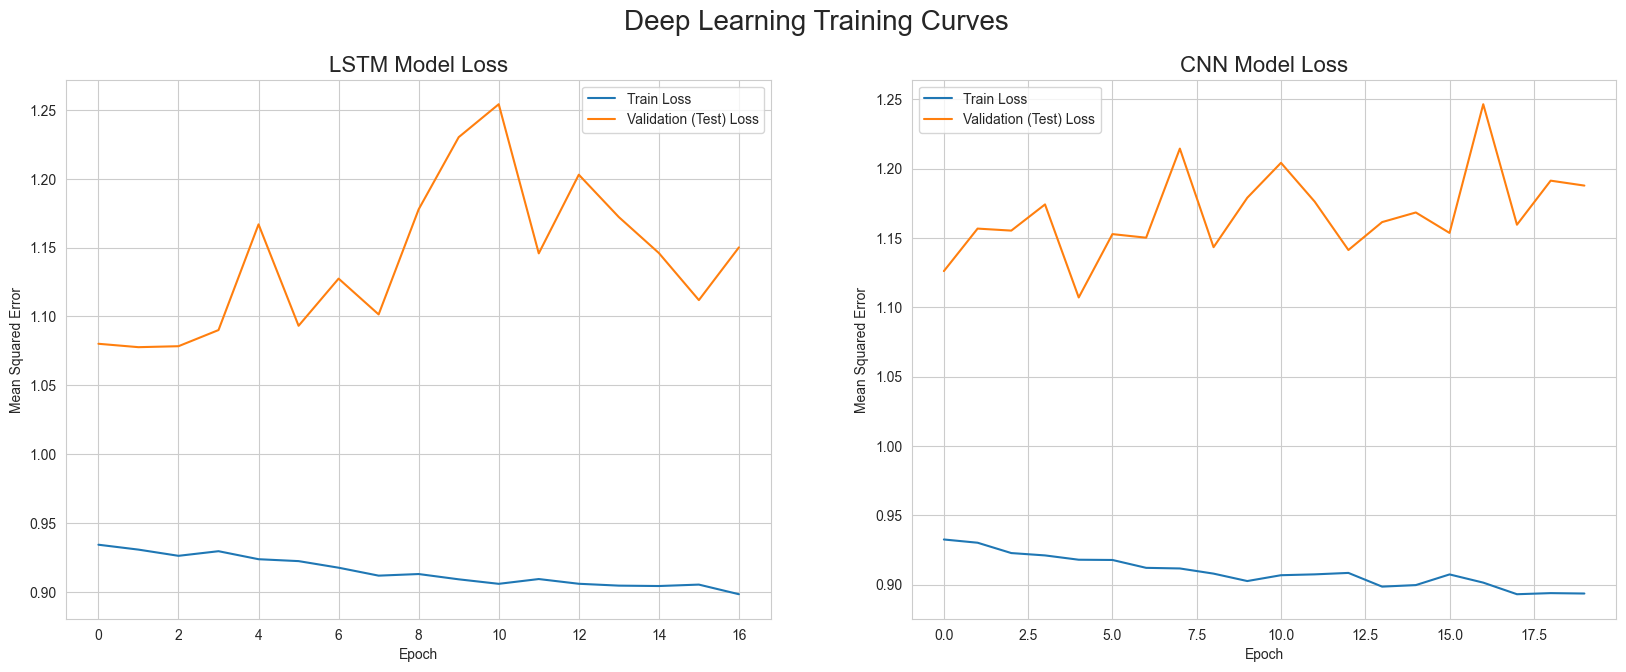

In [43]:
if RUN_MODELS['LSTM'] and RUN_MODELS['CNN']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    ax1.plot(train_losses_lstm, label='Train Loss')
    ax1.plot(val_losses_lstm, label='Validation (Test) Loss')
    ax1.set_title('LSTM Model Loss', fontsize=16)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Squared Error')
    ax1.legend()
    ax2.plot(train_losses_cnn, label='Train Loss')
    ax2.plot(val_losses_cnn, label='Validation (Test) Loss')
    ax2.set_title('CNN Model Loss', fontsize=16)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Squared Error')
    ax2.legend()
    plt.suptitle('Deep Learning Training Curves', fontsize=20)
    plt.savefig("loss_curves.png")
    plt.show()

## 10. Final Evaluation

In [44]:
# Align test sets
matched_test_df = pd.concat([group.iloc[LOOKBACK-1:] for _, group in test_df_dl.groupby(CAT_COLS) if len(group) >= LOOKBACK])
matched_test_ml_df = pd.concat([group.iloc[LOOKBACK-1:] for _, group in test_df.groupby(CAT_COLS) if len(group) >= LOOKBACK])
X_test_ml_matched = matched_test_ml_df[ML_FEATS]
X_test_dl_matched, y_test_det_matched = create_sequences(matched_test_df, 1, DL_FEATS, TARGET_DET)
y_test_det_matched = y_test_det_matched.flatten()
trend_test = matched_test_df['yield_trend'].values
y_true_original = matched_test_df[TARGET].values

# Predictions
test_preds = {}
for name in models:
    if name in ['LR', 'RF', 'XGB']:
        test_preds[name] = models[name].predict(X_test_ml_matched)
    elif name in ['LSTM', 'CNN']:
        X_test_dl_inputs_m = split_dl(X_test_seq)
        models[name].eval()
        with torch.no_grad():
            preds_scaled = models[name](*[x.to(device) for x in X_test_dl_inputs_m]).cpu().numpy()
            test_preds[name] = target_scaler.inverse_transform(preds_scaled).flatten()

# Evaluate
results = []
y_preds_original = {}
for name, pred_det in test_preds.items():
    pred_orig = pred_det + trend_test
    y_preds_original[name] = pred_orig
    mae = mean_absolute_error(y_true_original, pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_original, pred_orig))
    map_e = mape(y_true_original, pred_orig)
    rms_pe = rmspe(y_true_original, pred_orig)
    r_2 = r2_score(y_true_original, pred_orig)
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': map_e, 'RMSPE (%)': rms_pe, 'R²': r_2})

results_df = pd.DataFrame(results).set_index('Model').sort_values('RMSPE (%)')
print("\n--- Final Performance (Test Set) ---")
print(results_df.round(2))
results_df.to_csv("final_model_performance.csv")


--- Final Performance (Test Set) ---
           MAE      RMSE  MAPE (%)  RMSPE (%)    R²
Model                                              
RF     2211.53   6816.33      2.74       7.58  1.00
LR     2784.85   6692.22      3.47       8.49  1.00
XGB    3045.56   7494.11      3.96       9.09  0.99
CNN    6560.61  12365.14      8.00      17.14  0.99
LSTM   6276.66  12168.02      7.68      17.43  0.99


## 11. Plot Model Performances

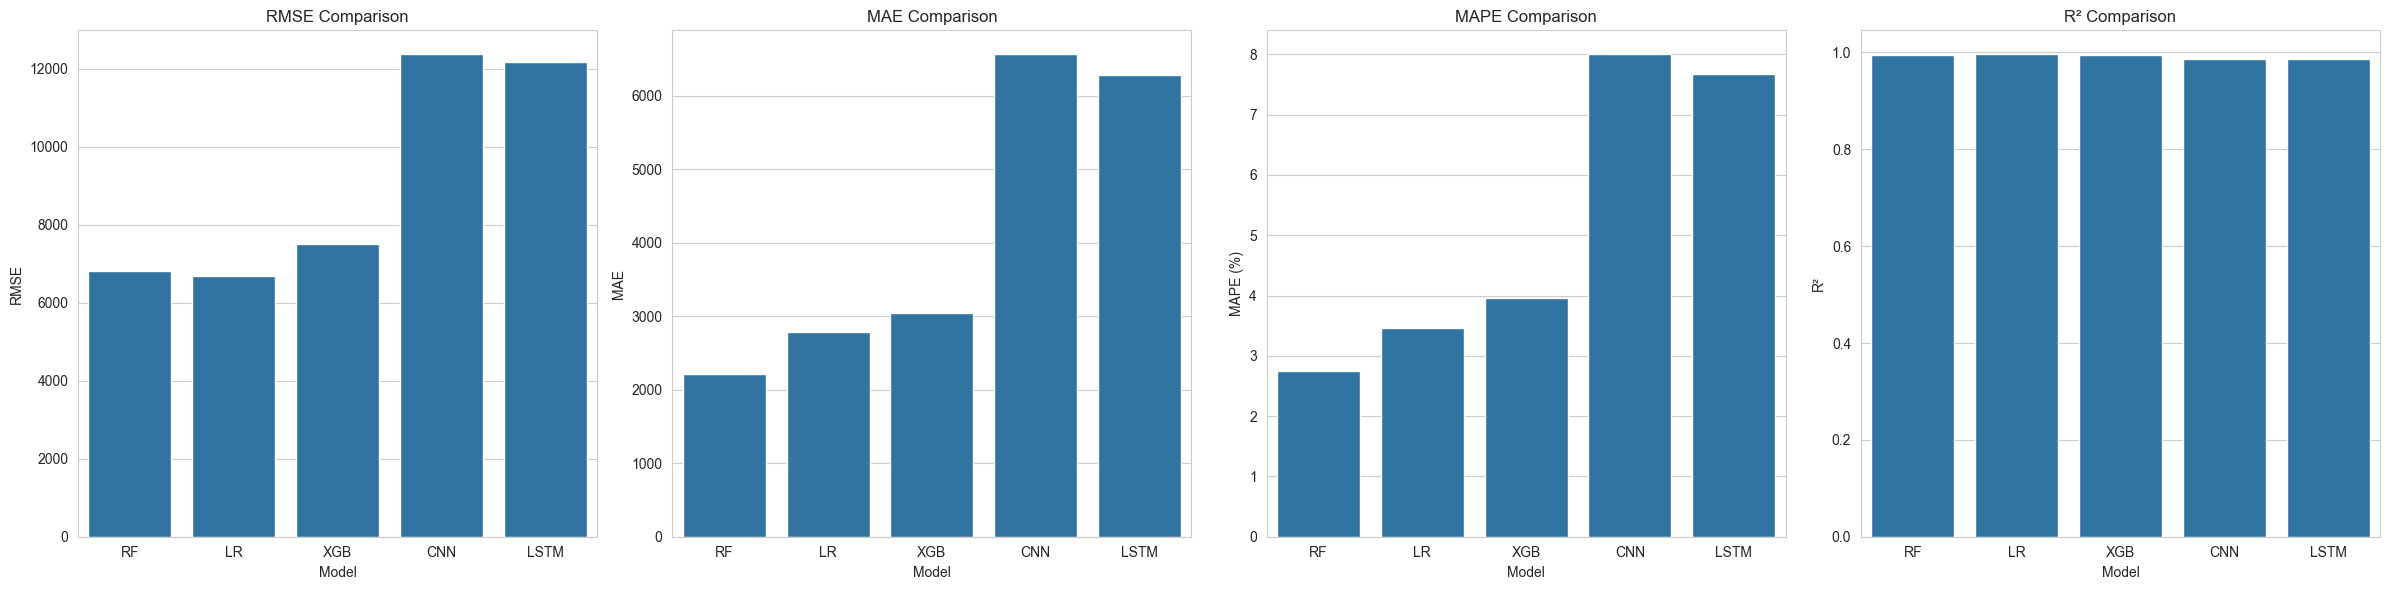

In [45]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
sns.barplot(data=results_df.reset_index(), x='Model', y='RMSE', ax=axs[0])
axs[0].set_title('RMSE Comparison')
sns.barplot(x='Model', y='MAE', data=results_df.reset_index(), ax=axs[1])
axs[1].set_title('MAE Comparison')
sns.barplot(x='Model', y='MAPE (%)', data=results_df.reset_index(), ax=axs[2])
axs[2].set_title('MAPE Comparison')
sns.barplot(x='Model', y='R²', data=results_df.reset_index(), ax=axs[3])
axs[3].set_title('R² Comparison')
plt.tight_layout()
plt.savefig("model_performance_comparison.png")
plt.show()

## 12. Per-Crop Reporting (Best Model)

In [46]:
best_model_name = results_df.index[0]
print(f"Per-crop report for best model: {best_model_name}")
crop_results = []
items = matched_test_df['Item'].values
for crop in np.unique(items):
    mask = items == crop
    true = y_true_original[mask]
    pred = y_preds_original[best_model_name][mask]
    crop_results.append({
        'Crop': crop,
        'RMSPE (%)': rmspe(true, pred),
        'MAPE (%)': mape(true, pred),
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'R²': r2_score(true, pred)
    })
crop_df = pd.DataFrame(crop_results).sort_values('RMSPE (%)')
print(crop_df.round(2))
crop_df.to_csv('per_crop_performance.csv', index=False)

Per-crop report for best model: RF
                   Crop  RMSPE (%)  MAPE (%)      RMSE    R²
9                  Yams       1.32      0.82   1843.05  1.00
4           Rice, paddy       3.32      1.51   2014.12  0.99
1                 Maize       3.78      2.04   2117.51  0.99
7        Sweet potatoes       4.13      2.33   6767.03  0.99
6              Soybeans       4.97      3.15    959.36  0.99
3              Potatoes       5.16      2.35  15077.49  0.96
8                 Wheat       5.46      2.82   1938.62  0.98
0               Cassava       7.22      2.47   5896.98  1.00
2  Plantains and others      11.38     10.02  15927.79  0.93
5               Sorghum      18.37      5.64   4977.79  0.91


## 13. SHAP Analysis (If Tree Model)

Running SHAP on RF


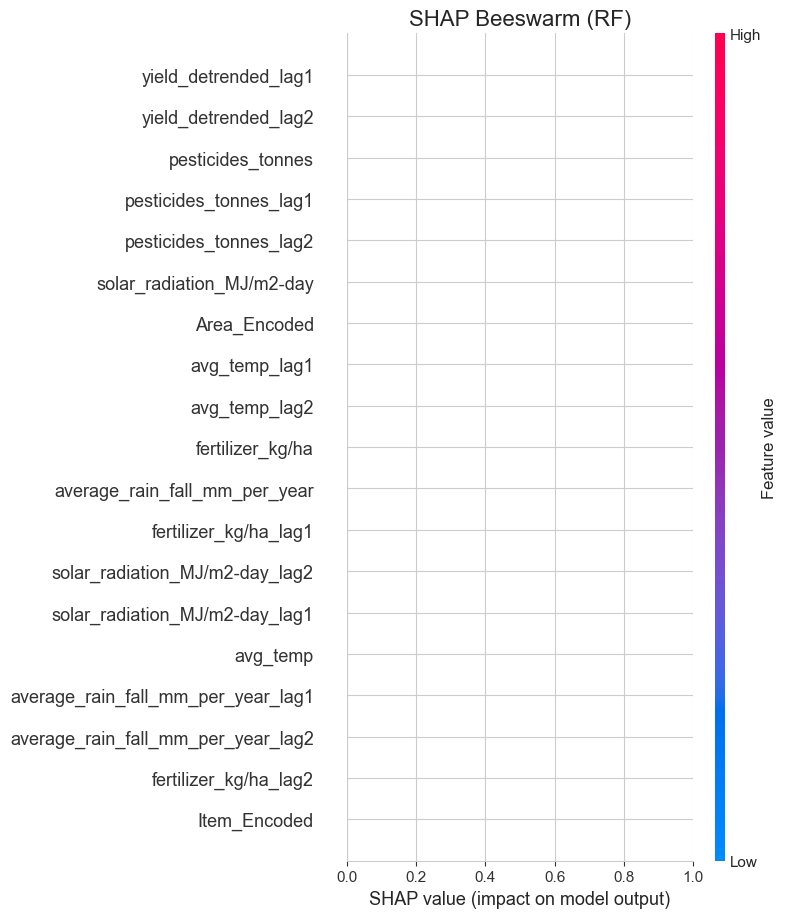

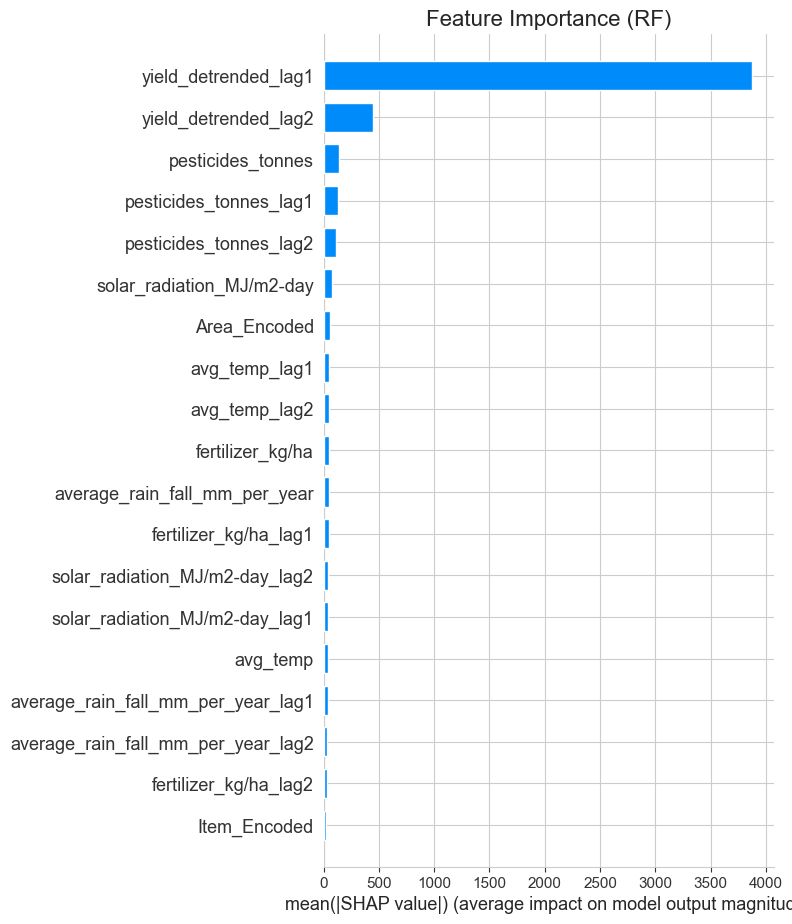

In [47]:
best_model_name = results_df.index[0]
if best_model_name in models and best_model_name in ['RF', 'XGB']:
    best_model = models[best_model_name]
    print(f"Running SHAP on {best_model_name}")
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_ml_matched)
    shap.summary_plot(shap_values, X_test_ml_matched, plot_type="beeswarm", show=False)
    plt.title(f"SHAP Beeswarm ({best_model_name})", fontsize=16)
    plt.savefig("shap_beeswarm.png", bbox_inches='tight')
    plt.show()
    shap.summary_plot(shap_values, X_test_ml_matched, plot_type="bar", show=False)
    plt.title(f"Feature Importance ({best_model_name})", fontsize=16)
    plt.savefig("shap_importance.png", bbox_inches='tight')
    plt.show()
else:
    print("SHAP skipped for non-tree model.")

## 14. Export Predictions

In [49]:
final_predictions_df = matched_test_df.copy()
final_predictions_df['true_yield_original'] = y_true_original
for name in test_preds:
    final_predictions_df[f'predicted_{name}'] = y_preds_original[name]
export_cols = ['Year', 'Area', 'Item', 'true_yield_original'] + [f'predicted_{name}' for name in test_preds]
final_predictions_df[export_cols].to_csv("final_test_predictions.csv", index=False)
print("Exported predictions.")
print("\n--- Complete ---")

Exported predictions.

--- Complete ---
